## 1.数据读取

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os

'''class DeepONetDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir  # 数据文件夹路径
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npz')]  # 获取所有 npz 文件
        
    def __len__(self):
        return len(self.files)  # 数据集的大小

    def __getitem__(self, idx):
        # 从文件中读取数据
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)
        
        # 获取 x_u, u, x_s, s
        x_u = torch.tensor(data['x_u'], dtype=torch.float32)
        u = torch.tensor(data['u'], dtype=torch.float32)
        x_s = torch.tensor(data['x_s'], dtype=torch.float32)
        s = torch.tensor(data['s'], dtype=torch.float32)
        
        return u, x_s, s  # 返回每个样本'''



"class DeepONetDataset(Dataset):\n    def __init__(self, data_dir):\n        self.data_dir = data_dir  # 数据文件夹路径\n        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npz')]  # 获取所有 npz 文件\n        \n    def __len__(self):\n        return len(self.files)  # 数据集的大小\n\n    def __getitem__(self, idx):\n        # 从文件中读取数据\n        file_path = os.path.join(self.data_dir, self.files[idx])\n        data = np.load(file_path)\n        \n        # 获取 x_u, u, x_s, s\n        x_u = torch.tensor(data['x_u'], dtype=torch.float32)\n        u = torch.tensor(data['u'], dtype=torch.float32)\n        x_s = torch.tensor(data['x_s'], dtype=torch.float32)\n        s = torch.tensor(data['s'], dtype=torch.float32)\n        \n        return u, x_s, s  # 返回每个样本"

## 2.模型构建

In [1]:
import torch
import torch.nn as nn

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim, output_size):
        super(DeepONet, self).__init__()

        # 分支网络（处理 u(x)）
        self.branch_net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),  # 输入1通道，输出32通道
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # 输入32通道，输出64通道
            nn.ReLU(),
            nn.Flatten(),  # 展平输出
            nn.Linear(64 * branch_input_dim, hidden_dim),  # 线性层：64 * branch_input_dim维度映射到hidden_dim维度
            nn.ReLU()
        )

        # 干道网络：处理 x(s)
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # 输出层
        self.output_layer = nn.Linear(hidden_dim, output_size)

    def forward(self, u, x):
        # 判断 u 的形状并确保其符合 Conv1d 的输入要求
        if u.dim() == 1:  # 如果 u 只有 1 维（[branch_input_dim]）
            u = u.unsqueeze(0).unsqueeze(0)  # 转换为 [1, 1, branch_input_dim]
        elif u.dim() == 2:  # 如果 u 已经是 2 维（[batch_size, branch_input_dim]）
            u = u.unsqueeze(1)  # 转换为 [batch_size, 1, branch_input_dim]

        # 处理输入函数 u(x)
        branch_out = self.branch_net(u)

        # 处理空间位置 x(s)
        trunk_out = self.trunk_net(x)

        # 结合分支和干道的输出
        combined = branch_out * trunk_out

        # 输出层
        output = self.output_layer(combined)
        return output



## 3.模型训练定义

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
import os


def load_npz_data(npz_file):
    """
    从NPZ文件加载数据
    """
    data = np.load(npz_file)
    x_u = torch.tensor(data['x_u'], dtype=torch.float32)
    u = torch.tensor(data['u'], dtype=torch.float32)
    x_s = torch.tensor(data['x_s'], dtype=torch.float32)
    s = torch.tensor(data['s'], dtype=torch.float32)
    return x_u, u, x_s, s


def train(model, optimizer, criterion, data_dir, epochs=100, threshold=1e-5, save_path='best_model.pth'):
    """
    训练模型，逐个读取NPZ文件进行训练，并根据损失阈值停止训练。
    保存最小损失的模型参数。
    
    参数:
    - model: 要训练的模型
    - optimizer: 优化器
    - criterion: 损失函数
    - data_dir: 数据文件夹路径
    - epochs: 最大训练轮次
    - threshold: 损失阈值，若损失小于该阈值则停止训练
    - save_path: 保存最小损失模型的路径
    """
    model.train()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 获取数据文件夹中的所有 .npz 文件
    npz_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')]
    
    best_loss = float('inf')  # 初始化最佳损失为正无穷
    for epoch in range(epochs + 1):
        total_loss = 0.0  # 记录当前 epoch 的总损失

        # 逐个读取NPZ文件进行训练
        for npz_file in npz_files:
            # 加载当前 .npz 文件的数据
            x_u, u, x_s, s = load_npz_data(npz_file)

            # 将数据移到GPU（如果有GPU）
            x_u, u, x_s, s = x_u.to(device), u.to(device), x_s.to(device), s.to(device)

            # 清空梯度
            optimizer.zero_grad()

            # 前向传播：假设模型接受 u 和 x_s 作为输入
            pred_s = model(u, x_s)

            # 计算损失
            loss = criterion(pred_s, s)

            # 反向传播
            loss.backward()

            # 优化
            optimizer.step()

            total_loss += loss.item()  # 累加损失

        # 计算当前epoch的平均损失
        average_loss = total_loss / len(npz_files)

        # 每隔10个epoch输出一次损失
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {average_loss}")

        # 如果当前损失小于最小损失，则保存模型参数
        if average_loss < best_loss:
            best_loss = average_loss
            torch.save(model.state_dict(), save_path)  # 保存最小损失时的模型

        # 如果损失小于阈值，则停止训练
        if average_loss < threshold:
            print(f"Loss {average_loss} is below the threshold {threshold}. Stopping training.")
            break

    # 返回训练后的模型
    return model


In [4]:
# 数据加载
data_dir = './raw_data_files'  # 数据文件夹路径
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型
model = DeepONet(branch_input_dim=100, trunk_input_dim=200, hidden_dim=64, output_size=200).to(device)

# 选择优化器（Adam 或其他）
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 选择损失函数（如均方误差）
criterion = nn.MSELoss()

# 训练模型
epochs = 1000
trained_model = train(model, optimizer, criterion, data_dir, epochs=1000)


c:\anacoda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([1, 200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.00981822628993541
Epoch 10, Loss: 0.0003269394103426748
Epoch 20, Loss: 7.866377804020885e-05
Epoch 30, Loss: 2.5939249494513204e-05
Epoch 40, Loss: 3.0289786388948413e-05
Epoch 50, Loss: 1.3024061759097095e-05
Epoch 60, Loss: 0.00010080762767302076
Epoch 70, Loss: 4.830657976299335e-05
Epoch 80, Loss: 3.462616963133769e-05
Epoch 90, Loss: 0.00012005326551843609
Epoch 100, Loss: 2.2800175595421025e-05
Epoch 110, Loss: 7.28448285531158e-05
Epoch 120, Loss: 3.5529111694359014e-05
Epoch 130, Loss: 1.6636358793675754e-05
Epoch 140, Loss: 7.531611636068192e-05
Epoch 150, Loss: 3.6668557597749896e-05
Epoch 160, Loss: 1.0936744812397592e-05
Epoch 170, Loss: 1.8073700405238925e-05
Epoch 180, Loss: 2.9155904308026947e-05
Loss 9.836672194296626e-06 is below the threshold 1e-05. Stopping training.


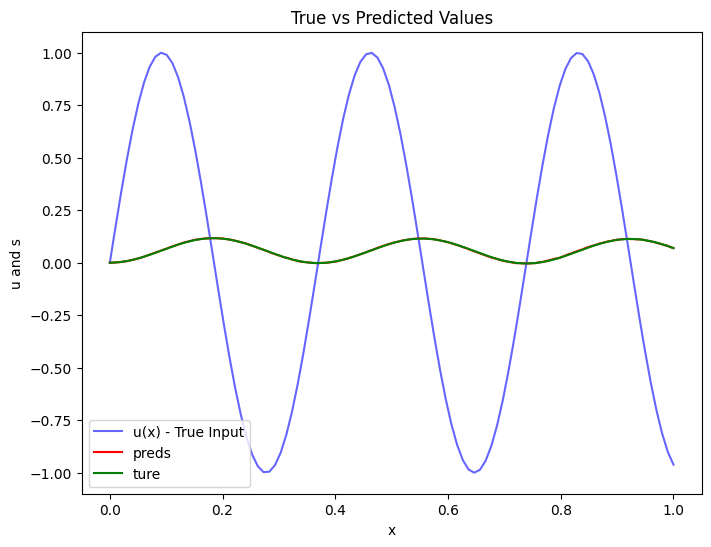

In [22]:
model.eval()  # 切换到评估模式
import matplotlib.pyplot as plt

t = np.linspace(0,1,100)
u = np.sin(17*t)
x = np.linspace(0,1,200)

# 微分方程的右侧，即 f(x, s) = -s^2 + u(x)
def f(x, s, u_func):
    return -s**2 + u_func(x)

# 使用RK4方法求解微分方程
def runge_kutta_4(f, u_func, x, s0, h):
    # 初始化解
    s = np.zeros_like(x)
    s[0] = s0  # 初始条件 s(0) = s0
    
    # RK4迭代
    for i in range(1, len(x)):
        # 计算每一步的k1, k2, k3, k4
        k1 = h * f(x[i-1], s[i-1], u_func)
        k2 = h * f(x[i-1] + h/2, s[i-1] + k1/2, u_func)
        k3 = h * f(x[i-1] + h/2, s[i-1] + k2/2, u_func)
        k4 = h * f(x[i-1] + h, s[i-1] + k3, u_func)
        
        # 更新解
        s[i] = s[i-1] + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return s

u_func = lambda x: np.sin(17* x)

# 使用RK4方法求解S(x)
ture_s = runge_kutta_4(f, u_func, x, s0=0, h=(x[1] - x[0]))

u_tensor = torch.tensor(u).unsqueeze(0).unsqueeze(0).float()  # 转换为[1, 1, 100]
x_tensor = torch.tensor(x).unsqueeze(0).float()  # 转换为[1, 200]


with torch.no_grad():
    # 模型预测
    pred_s = model(u_tensor, x_tensor)
    pred_s = pred_s.numpy().flatten()
    # 收集预测值和真实值

# 绘制预测值与真实值的对比图
plt.figure(figsize=(8, 6))
plt.plot(t, u, color='blue', alpha=0.6, label='u(x) - True Input')
plt.plot(x, pred_s,color='r', label = 'preds' )
plt.plot(x, ture_s,color='g', label = 'ture' )
plt.xlabel("x")
plt.ylabel("u and s")
plt.title("True vs Predicted Values")
plt.legend()
plt.show()

## 3.测试逆向效果:

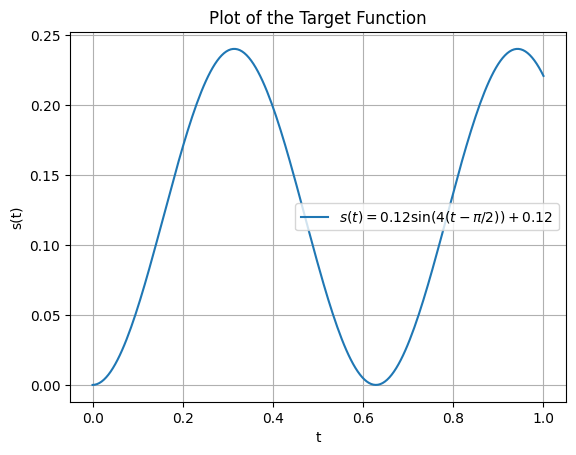

In [2]:
#生成目标数据
import numpy as np
import matplotlib.pyplot as plt

# Define the range for t
t = np.linspace(0, 1, 200)

# Define the target function
s_target = 0.12 * np.sin(10* (t - np.pi / (2*10))) + 0.12

#print(s_target)

# Plot the function
plt.plot(t, s_target, label=r"$s(t) = 0.12\sin(4(t - \pi/2)) + 0.12$")
plt.xlabel("t")
plt.ylabel("s(t)")
plt.title("Plot of the Target Function")
plt.grid(True)
plt.legend()
plt.show()


C:\Users\19464\AppData\Local\Temp\ipykernel_16488\1641081639.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
C:\Users

Epoch 100, Loss: 0.008038
Epoch 200, Loss: 0.007015
Epoch 300, Loss: 0.006177
Epoch 400, Loss: 0.005397
Epoch 500, Loss: 0.004862
Epoch 600, Loss: 0.004166
Epoch 700, Loss: 0.003597
Epoch 800, Loss: 0.003262
Epoch 900, Loss: 0.003097
Epoch 1000, Loss: 0.003042
Epoch 1100, Loss: 0.003003
Epoch 1200, Loss: 0.002964
Epoch 1300, Loss: 0.002903
Epoch 1400, Loss: 0.002810
Epoch 1500, Loss: 0.002727
Epoch 1600, Loss: 0.002467
Epoch 1700, Loss: 0.001910
Epoch 1800, Loss: 0.001608
Epoch 1900, Loss: 0.001232
Epoch 2000, Loss: 0.001010
Epoch 2100, Loss: 0.000931
Epoch 2200, Loss: 0.000912
Epoch 2300, Loss: 0.000910
Epoch 2400, Loss: 0.000915
Epoch 2500, Loss: 0.000918
Epoch 2600, Loss: 0.000916
Epoch 2700, Loss: 0.000917
Epoch 2800, Loss: 0.000912
Epoch 2900, Loss: 0.000905
Epoch 3000, Loss: 0.000899
Epoch 3100, Loss: 0.000888
Epoch 3200, Loss: 0.000889
Epoch 3300, Loss: 0.000891
Epoch 3400, Loss: 0.000892
Epoch 3500, Loss: 0.000893
Epoch 3600, Loss: 0.000894
Epoch 3700, Loss: 0.000894
Epoch 3800

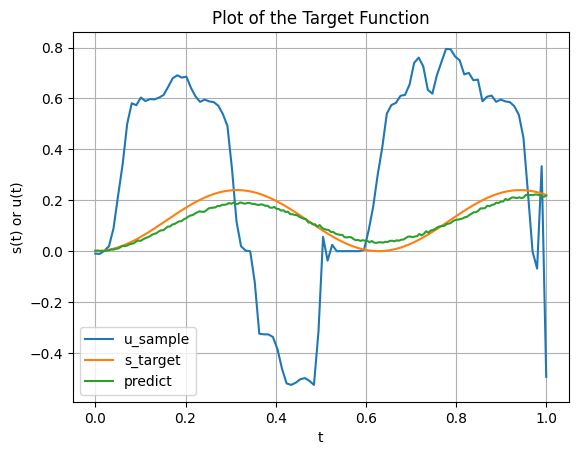

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#模型加载
device = 'cpu'
model = DeepONet(branch_input_dim=100, trunk_input_dim=200, hidden_dim=64, output_size=200).to(device)
model.load_state_dict(torch.load('best_model.pth'))

# 假设 t 和 s_target 已经给定
# 直接初始化 u_sample 为叶张量
u_sample0 = 2*torch.rand(1, 1, 100)-1  # 创建一个叶张量
u_sample = torch.tensor(u_sample0,dtype=torch.float32, requires_grad= True)


# 假设 t_target 和 s_target 已经给定，确保它们是正确的类型
t_target = torch.tensor(t, dtype=torch.float32).unsqueeze(0).float()
s_target1 = torch.tensor(s_target, dtype=torch.float32).unsqueeze(0)

# 冻结模型参数
for param in model.parameters():
    param.requires_grad = False

# 初始化优化器
optimizer = torch.optim.Adam([u_sample], lr=0.001, weight_decay=1e-4)

# 损失函数
loss_fn = nn.MSELoss()

# 训练过程
epochs = 5000
for epoch in range(epochs):
    # 前向传播
    outputs = model(u_sample, t_target)
    loss = loss_fn(outputs, s_target1)

    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 每100个epoch输出一次损失
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


model.eval()  # 切换到评估模式


with torch.no_grad():
    # 模型预测
    pred_st = model(u_sample, t_target)
    pred_st = pred_st.numpy().flatten()
    # 收集预测值和真实值


# 绘制 u_sample 和 s_target 的对比
plt.plot(np.linspace(0,1,100), u_sample.detach().numpy().flatten())  # 转换为 NumPy 数组
plt.plot(t_target.numpy().flatten(), s_target1.numpy().flatten())  # 同样转换为 NumPy 数组
plt.plot(t_target.numpy().flatten(), pred_st)
plt.xlabel("t")
plt.ylabel("s(t) or u(t)")
plt.title("Plot of the Target Function")
plt.grid(True)
plt.legend(["u_sample", "s_target",'predict'])
plt.show()


## 尝试将数据平滑化，看看能不能优化结果

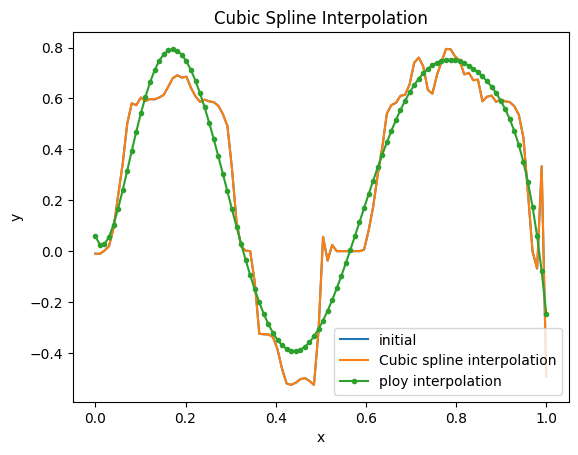

In [28]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt

# 使用scipy的CubicSpline进行三次样条插值
spline = interp.CubicSpline(np.linspace(0,1,100), u_sample.detach().numpy().flatten(), bc_type='natural')  # 'natural'表示自然边界条件

# 计算插值函数在给定点的值
y_new = spline(np.linspace(0,1,100))  # 计算插值结果

# 多项式拟合
coefficients = np.polyfit(np.linspace(0,1,100), u_sample.detach().numpy().flatten(), 7)

# 生成拟合的多项式函数
poly = np.poly1d(coefficients)

# 生成平滑的拟合曲线
y_smooth = poly(np.linspace(0,1,100))

# 绘图显示插值效果
plt.plot(np.linspace(0,1,100), u_sample.detach().numpy().flatten(),label = 'initial')  # 转换为 NumPy 数组
plt.plot(np.linspace(0,1,100), y_new, '-', label='Cubic spline interpolation')
plt.plot(np.linspace(0,1,100), y_smooth, '.-', label='ploy interpolation')
plt.legend()
plt.title('Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

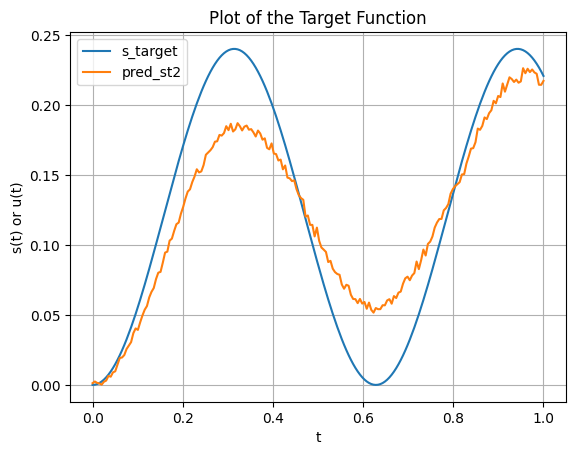

In [29]:
model.eval()  # 切换到评估模式

y_smooth1 =  torch.tensor(y_smooth, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    # 模型预测
    pred_st2 = model(y_smooth1, t_target)
    pred_st2 = pred_st2.numpy().flatten()
    # 收集预测值和真实值


# 绘制 u_sample 和 s_target 的对比
plt.plot(t_target.numpy().flatten(), s_target1.numpy().flatten())  # 同样转换为 NumPy 数组
plt.plot(t_target.numpy().flatten(), pred_st2)
plt.xlabel("t")
plt.ylabel("s(t) or u(t)")
plt.title("Plot of the Target Function")
plt.grid(True)
plt.legend(["s_target", "pred_st2"])
plt.show()

#### 尝试将平滑数据优化，结果还是哪个结果。这或许是因为给定的S解本身可能并不存在？

Epoch 100, Loss: 0.000939
Epoch 200, Loss: 0.000917
Epoch 300, Loss: 0.000903
Epoch 400, Loss: 0.000893
Epoch 500, Loss: 0.000891
Epoch 600, Loss: 0.000889
Epoch 700, Loss: 0.000889
Epoch 800, Loss: 0.000888
Epoch 900, Loss: 0.000888
Epoch 1000, Loss: 0.000888
Epoch 1100, Loss: 0.000888
Epoch 1200, Loss: 0.000888
Epoch 1300, Loss: 0.000888
Epoch 1400, Loss: 0.000888
Epoch 1500, Loss: 0.000887
Epoch 1600, Loss: 0.000888
Epoch 1700, Loss: 0.000888
Epoch 1800, Loss: 0.000888
Epoch 1900, Loss: 0.000888
Epoch 2000, Loss: 0.000887
Epoch 2100, Loss: 0.000888
Epoch 2200, Loss: 0.000887
Epoch 2300, Loss: 0.000888
Epoch 2400, Loss: 0.000888
Epoch 2500, Loss: 0.000888
Epoch 2600, Loss: 0.000888
Epoch 2700, Loss: 0.000887
Epoch 2800, Loss: 0.000888
Epoch 2900, Loss: 0.000888
Epoch 3000, Loss: 0.000888
Epoch 3100, Loss: 0.000888
Epoch 3200, Loss: 0.000888
Epoch 3300, Loss: 0.000887
Epoch 3400, Loss: 0.000887
Epoch 3500, Loss: 0.000888
Epoch 3600, Loss: 0.000888
Epoch 3700, Loss: 0.000887
Epoch 3800

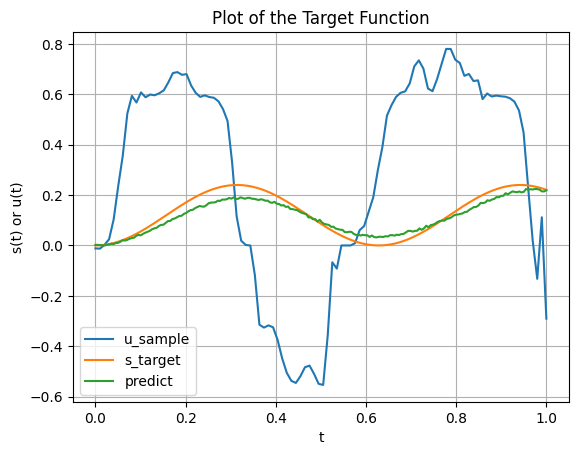

In [33]:
u_sample = torch.tensor(y_smooth, dtype=torch.float32,requires_grad=True)

# 假设 t_target 和 s_target 已经给定，确保它们是正确的类型
t_target = torch.tensor(t, dtype=torch.float32).unsqueeze(0).float()
s_target1 = torch.tensor(s_target, dtype=torch.float32).unsqueeze(0)

# 冻结模型参数
for param in model.parameters():
    param.requires_grad = False

# 初始化优化器
optimizer = torch.optim.Adam([u_sample], lr=0.001, weight_decay=1e-4)

# 损失函数
loss_fn = nn.MSELoss()

# 训练过程
epochs = 5000
for epoch in range(epochs):
    # 前向传播
    outputs = model(u_sample, t_target)
    loss = loss_fn(outputs, s_target1)

    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 每100个epoch输出一次损失
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


model.eval()  # 切换到评估模式


with torch.no_grad():
    # 模型预测
    pred_st = model(u_sample, t_target)
    pred_st = pred_st.numpy().flatten()
    # 收集预测值和真实值


# 绘制 u_sample 和 s_target 的对比
plt.plot(np.linspace(0,1,100), u_sample.detach().numpy().flatten())  # 转换为 NumPy 数组
plt.plot(t_target.numpy().flatten(), s_target1.numpy().flatten())  # 同样转换为 NumPy 数组
plt.plot(t_target.numpy().flatten(), pred_st)
plt.xlabel("t")
plt.ylabel("s(t) or u(t)")
plt.title("Plot of the Target Function")
plt.grid(True)
plt.legend(["u_sample", "s_target",'predict'])
plt.show()


#### 尝试从数据集中抽取目标函数，看看是否能反向优化出来结果

C:\Users\19464\AppData\Local\Temp\ipykernel_16488\567804321.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_sample = torch.tensor(u_sample0,dtype=torch.float32, requires_grad= True)


Epoch 100, Loss: 0.046010
Epoch 200, Loss: 0.040833
Epoch 300, Loss: 0.036284
Epoch 400, Loss: 0.030310
Epoch 500, Loss: 0.022973
Epoch 600, Loss: 0.016187
Epoch 700, Loss: 0.009778
Epoch 800, Loss: 0.005688
Epoch 900, Loss: 0.003424
Epoch 1000, Loss: 0.002160
Epoch 1100, Loss: 0.001349
Epoch 1200, Loss: 0.000871
Epoch 1300, Loss: 0.000621
Epoch 1400, Loss: 0.000460
Epoch 1500, Loss: 0.000351
Epoch 1600, Loss: 0.000293
Epoch 1700, Loss: 0.000254
Epoch 1800, Loss: 0.000220
Epoch 1900, Loss: 0.000198
Epoch 2000, Loss: 0.000183
Epoch 2100, Loss: 0.000171
Epoch 2200, Loss: 0.000162
Epoch 2300, Loss: 0.000157
Epoch 2400, Loss: 0.000159
Epoch 2500, Loss: 0.000164
Epoch 2600, Loss: 0.000172
Epoch 2700, Loss: 0.000177
Epoch 2800, Loss: 0.000177
Epoch 2900, Loss: 0.000179
Epoch 3000, Loss: 0.000176
Epoch 3100, Loss: 0.000177
Epoch 3200, Loss: 0.000177
Epoch 3300, Loss: 0.000177
Epoch 3400, Loss: 0.000178
Epoch 3500, Loss: 0.000177
Epoch 3600, Loss: 0.000179
Epoch 3700, Loss: 0.000179
Epoch 3800

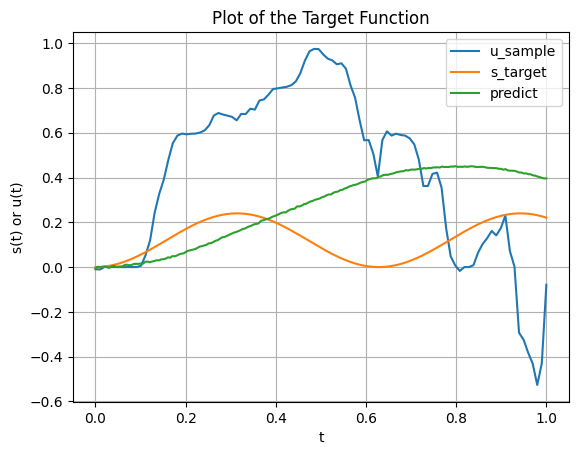

In [48]:

data =np.load('raw_data_files/raw_data_1.npz')

u_sample0 = 2*torch.rand(1, 1, 100)-1  # 创建一个叶张量
u_sample = torch.tensor(u_sample0,dtype=torch.float32, requires_grad= True)

# 假设 t_target 和 s_target 已经给定，确保它们是正确的类型
t_target = torch.tensor(data['x_s'], dtype=torch.float32).unsqueeze(0).float()
s_target = torch.tensor(data['s'], dtype=torch.float32).unsqueeze(0)

# 冻结模型参数
for param in model.parameters():
    param.requires_grad = False

# 初始化优化器
optimizer = torch.optim.Adam([u_sample], lr=0.001, weight_decay=1e-4)

# 损失函数
loss_fn = nn.MSELoss()

# 训练过程
epochs = 10000
for epoch in range(epochs):
    # 前向传播
    outputs = model(u_sample, t_target)
    loss = loss_fn(outputs, s_target)

    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 每100个epoch输出一次损失
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


model.eval()  # 切换到评估模式


with torch.no_grad():
    # 模型预测
    pred_st = model(u_sample, t_target)
    pred_st = pred_st.numpy().flatten()
    # 收集预测值和真实值


# 绘制 u_sample 和 s_target 的对比
plt.plot(data['x_u'], u_sample.detach().numpy().flatten())  # 转换为 NumPy 数组
plt.plot(t_target.numpy().flatten(), s_target1.numpy().flatten())  # 同样转换为 NumPy 数组
plt.plot(t_target.numpy().flatten(), pred_st)
#plt.plot(data['x_u'], u_sample0.detach().numpy().flatten())
plt.xlabel("t")
plt.ylabel("s(t) or u(t)")
plt.title("Plot of the Target Function")
plt.grid(True)
plt.legend(["u_sample", "s_target",'predict'])
plt.show()
